In [2]:
import sys
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import logging
import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset

# 전처리

In [3]:
import re

def clean_text(text):
    # 연도 값으로 시작하는 경우
    text = re.sub(r'^(19|20|21)\d{2}', ' ', text)
    
    # 월 값으로 시작하는 경우
    text = re.sub(r'^(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', ' ', text)
    
    # 시간 형식 (HH:MM:SS)
    text = re.sub(r'\d{2}:\d{2}:\d{2}', ' ', text)
    
    # "pid" 키와 숫자
    text = re.sub(r'"pid"\s?:\s?\d+,?\s?', ' ', text)
    # text = re.sub(r'"pid":\s?\d+,?\s?', '', text)

    # pid 제거로 제거되지 않은 대괄호 안의 pid 숫자 제거
    text = re.sub(r'\[\d+\]', ' ', text)
    
    # "port" 다음에 오는 숫자
    text = re.sub(r'port\s?\d{1,5}', ' ', text)

    # IP 주소
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' ', text)
    
    # "@timestamp" 형식
    text = re.sub(r'"@timestamp"\s?:\s?"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z?"', ' ', text)
    
    # 날짜 형식 (YYYY-MM-DD)
    text = re.sub(r'\d{2,4}-\d{1,2}-\d{1,2}', ' ', text)
    
    # 마침표, 쉼표, 공백, - 이 2개 이상 연속으로 존재하고, A,B,T,Z 또는 ms가 없거나 1개 있다면 제거
    text = re.sub(r'[\.\d,\s-]+([ABTZ]|ms)?', ' ', text)
    
    # 정규 표현식을 사용하여 특수문자 제거
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    return text

In [4]:
df = pd.read_csv("./log_data/train.csv")
df

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...
...,...,...,...
472967,472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:
472968,472968,1,type=SYSCALL msg=audit(1611890993.458:321827):...
472969,472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log..."
472970,472970,0,"Jan 15 09:02:43 localhost kibana: {""type"":""err..."


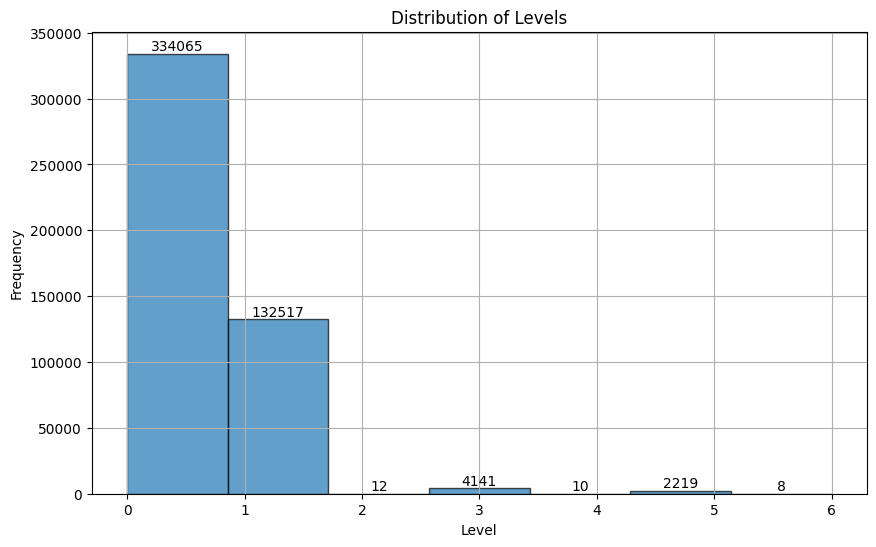

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df['level'], bins=7, edgecolor='k', alpha=0.7)
plt.title('Distribution of Levels')
plt.xlabel('Level')
plt.ylabel('Frequency')
plt.grid(True)

# 각 레벨별 개수 계산
counts = df['level'].value_counts().sort_index()

# 각 막대 위에 텍스트 추가
for count, bin_edge in zip(n, bins[:-1]):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.show()


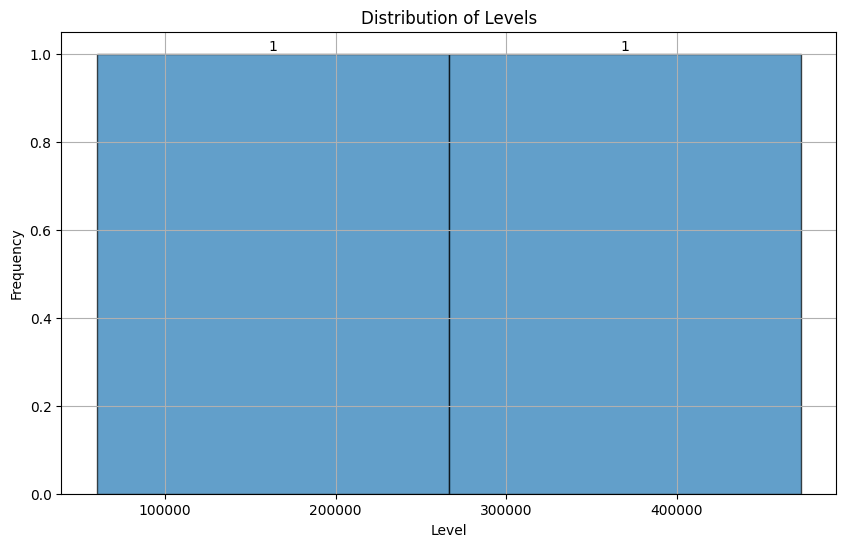

In [39]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist([472972 ,59791], bins=2, edgecolor='k', alpha=0.7)
plt.title('Distribution of Levels')
plt.xlabel('Level')
plt.ylabel('Frequency')
plt.grid(True)

# 각 레벨별 개수 계산
counts = df['level'].value_counts().sort_index()

# 각 막대 위에 텍스트 추가
for count, bin_edge in zip(n, bins[:-1]):
    plt.text(bin_edge + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

plt.show()

In [16]:
import pandas as pd


# 각 항목에 대해 단어 개수를 계산하는 함수 정의
def count_words(log_entry):
    return len(log_entry.split(" "))

# apply 메서드를 사용하여 각 항목에 대해 단어 개수를 계산하고 새로운 컬럼에 저장
df['word_count'] = df['full_log'].apply(count_words)

# 결과 출력
print(df)



                                                full_log  level  word_count
0       localhost kibana typeerror timestamp   tagswa...      0          41
1       localhost logstash   INFO logstash outputs el...      0          39
2      typeSYSCALL gaudit   archc e syscall successye...      1          74
3      typeSYSCALL gaudit   archc e syscall successye...      1          81
4       localhost logstash   WARN logstash outputs el...      0          34
...                                                  ...    ...         ...
59786   localhost sshd  ad protocol version identific...      6          12
59787   localhost kernel device virbr nic entered pro...      6           9
59788   localhost kernel device enp s entered promisc...      6           9
59789         localhost useradd  new group nametest GID       6           9
59790   localhost sshd  error maximum authentication ...      6          14

[59791 rows x 3 columns]


In [ ]:
max(df['word_count'])

10424

In [36]:
max(df['word_count'])

10424

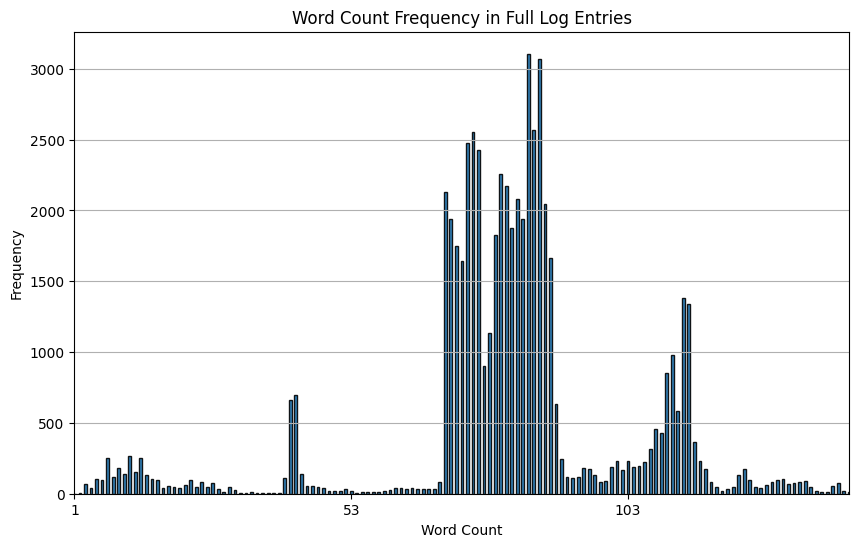

In [35]:
# word_count의 빈도 계산
word_count_freq = df['word_count'].value_counts().sort_index()

# 빈도수를 바 그래프로 시각화
plt.figure(figsize=(10, 6))
word_count_freq.plot(kind='bar', edgecolor='k', alpha=0.9)
plt.title('Word Count Frequency in Full Log Entries')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.xticks(range(0, max(df['word_count']) + 1, 50), rotation=0)
plt.xlim(0,140)
plt.show()

In [22]:
seven = pd.read_csv("level_7.csv")
seven

,id,full_log,is_level_7
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err...",True
1,1000042,type=SYSCALL msg=audit(1603156086.720:129819):...,True
2,1000071,Jan 29 04:23:06 localhost logstash: 3556 S...,True
3,1000082,"Jan 19 04:37:23 localhost kibana: {""type"":""err...",True
4,1000083,Jan 18 09:27:39 localhost logstash: [2021-01-1...,True
...,...,...,...
830,1059446,type=SYSCALL msg=audit(1611888551.744:226950):...,True
831,1059488,"Jan 13 00:30:29 localhost kibana: {""type"":""err...",True
832,1059497,type=SYSCALL msg=audit(1603072770.869:706): ar...,True
833,1059569,Feb 16 04:13:00 localhost logstash: [2021-02-1...,True


### 추출한 7분류 데이터와 train(0~6) dataframe 합치기

In [26]:
id = np.concatenate((df['id'].values,seven['id'].values))
full_log = np.concatenate((df['full_log'].values,seven['full_log'].values))
level= np.concatenate((df['level'].values,np.array([7]*len(seven))))

new_df = pd.DataFrame({'id': id, 'level': level, 'full_log': full_log})
new_df.to_csv("train_append_7.csv",index = False)
df = new_df
new_df

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...
...,...,...,...
473802,1059446,7,type=SYSCALL msg=audit(1611888551.744:226950):...
473803,1059488,7,"Jan 13 00:30:29 localhost kibana: {""type"":""err..."
473804,1059497,7,type=SYSCALL msg=audit(1603072770.869:706): ar...
473805,1059569,7,Feb 16 04:13:00 localhost logstash: [2021-02-1...


In [4]:
# 전처리 수행
df['full_log'] = df['full_log'].apply(clean_text)
df.to_csv("clean_train_7.csv", index=False)

# 중복제거

In [5]:
# 텍스트당 지정된 라벨과 개수를 저장
db = {}  # {텍스트: 레벨: 개수}
with tqdm(total=len(df), ncols=100, file=sys.stdout) as t:
    for i, (level, full_log) in enumerate(zip(df.level, df.full_log)):
        text = full_log
        if text not in db:
            db[text] = {}
        if level not in db[text]:
            db[text][level] = {"cnt": 0, "list": []}
        db[text][level]["cnt"] += 1
        db[text][level]["list"].append(i)

        t.update()

keys = list(db.keys())
len(keys), len(df)
# 여러 라벨로 분류된 텍스트 하나만 선택
outdb = {"level": [], "text": []}
with tqdm(total=len(keys), ncols=100, file=sys.stdout) as t:
    for key in keys:
        d = db[key]
        if len(list(d.keys())) > 1:
            # 가장 개수가 많은 level을 선택
            cnts = sorted([(d[k]["cnt"], k) for k in d.keys()], reverse=True)

            # 만약 개수가 같은게 있다면 가장 level이 작은 것을 선택
            max_cnt = cnts[0][0]
            same_ks = list(filter(lambda x: x[0] == max_cnt, cnts))
            level = same_ks[-1][1]
        else:
            level = list(d.keys())[0]

        outdb["level"].append(level)
        outdb["text"].append(key)
        t.update()

100%|█████████████████████████████████████████████████████| 59711/59711 [00:00<00:00, 237927.53it/s]


In [6]:
data = pd.DataFrame({'full_log': outdb['text'], 'level': outdb['level']})
data.to_csv("removed_duplicate_train_7.csv",index=False)
data

,full_log,level
0,localhost kibana typeerror timestamp tagswa...,0
1,localhost logstash INFO logstash outputs el...,0
2,typeSYSCALL gaudit archc e syscall successye...,1
3,typeSYSCALL gaudit archc e syscall successye...,1
4,localhost logstash WARN logstash outputs el...,0
...,...,...
59706,typeSYSCALL gaudit archc e syscall successye...,1
59707,typeSYSCALL gaudit archc e syscall successye...,1
59708,typeSYSCALL gaudit archc e syscall successye...,1
59709,typeSYSCALL gaudit archc e syscall successye...,1


In [7]:
# 데이터 확인
[len(data[data['level'] == i]) for i in range(0,8)]

[3476, 55090, 1, 527, 2, 610, 5, 0]

In [8]:
# 데이터 복제
temp = pd.concat([data[data['level'] == 2],data[data['level'] == 4],data[data['level'] == 6]])
for _ in range(10):
    data = pd.concat([data,temp])
    print(len(data))
data.to_csv("EDA_Dup_Oversampling.csv",index = False)

59719
59727
59735
59743
59751
59759
59767
59775
59783
59791


In [12]:
data['level'].value_counts(),len(data)

(1    55090
 0     3476
 5      610
 3      527
 6       55
 4       22
 2       11
 Name: level, dtype: int64,
 59791)

# validation 데이터 전처리 및 Oversampling 수행

In [8]:
df = pd.read_csv("./log_data/test.csv")
df['full_log'] = df['full_log'].apply(clean_text)
df

,id,full_log
0,1000000,localhost kibana typeerror timestamp tagswa...
1,1000001,localhost kibana typeerror timestamp tagswa...
2,1000002,typeSYSCALL gaudit archc e syscall successye...
3,1000003,localhost kibana typeerror timestamp tagswa...
4,1000004,typeSYSCALL gaudit archc e syscall successye...
...,...,...
1418911,2418911,localhost kibana typeerror timestamp tagswa...
1418912,2418912,localhost kibana typelog timestamp tagserro...
1418913,2418913,typeSYSCALL gaudit archc e syscall successye...
1418914,2418914,localhost logstash WARN logstash outputs el...


In [11]:
df.to_csv("EDA_submission.csv",index = False)

#

In [2]:
import pandas as pd
submission = pd.read_csv("EDA_submission.csv")

In [1]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import numpy as np

file_path = 'EDA_Dup_Oversampling.csv'
df = pd.read_csv(file_path)
# 입력 문장과 레이블 추출
sentences = df['full_log'].tolist()

# DistilBERT 토크나이저 로드
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# 문장을 토큰화하고 패딩
tokenized_texts = [tokenizer.encode_plus(
    sent,
    add_special_tokens=True,
    max_length=200,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
) for sent in sentences]

# 입력 IDs와 어텐션 마스크 추출 및 스택
input_ids = torch.cat([item['input_ids'] for item in tokenized_texts], dim=0)
attention_masks = torch.cat([item['attention_mask'] for item in tokenized_texts], dim=0)

c:\Users\민병창\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch


# 텐서를 파일로 저장
file_path ='MyDrive/train_masks.pt'
torch.save(attention_masks, file_path)

print(f"Tensor saved to {file_path}")
# 텐서를 파일로 저장
file_path = 'MyDrive/train_ids.pt'
torch.save(input_ids, file_path)

print(f"Tensor saved to {file_path}")

Tensor saved to MyDrive/train_masks.pt
Tensor saved to MyDrive/train_ids.pt
